## Clustering

In [48]:
from __future__ import division
%matplotlib inline
%pylab inline
import csv
import sys
import os
import traceback
import json
import pickle
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.externals import joblib
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Load decomposed segments from matlab

In [ ]:
mat_dir = "./symbolization_mat"
files = getListOfFiles(mat_dir, ".mat")
print ">> {} mat Files found:\n".format(len(files))
print json.dumps(files)
print
original_files = []
for f in files:
    original_files.append('.'.join(f.split('.')[0:2]))

print ">> {} Original CSV Files:\n".format(len(original_files))
print json.dumps(original_files)

In [3]:
segments = []
count = 0
min_length = float('inf')
for f in files:
    mat_content = sio.loadmat(os.path.join(mat_dir, f))
    #print mat_content
    data = mat_content['c_sym']
    #print data.tolist()[0]
    for d in data.tolist()[0]:
        if d[0].size == 0:
            pass
        else:
            count += 1
            sample = [i[0] for i in d.tolist()]
            if len(sample) < min_length:
                min_length = len(sample)
            segments.append(sample)

assert (len(segments) == count)
print 'N. of segments {}'.format(count)
print 'Min. sample size of {}'.format(min_length)

N. of segments 613
Min. sample size of 50


## Turning into list of strings

In [ ]:
for l in range(len(segments)):
    segments[l] = ''.join(map(str, segments[l]))

pre_view = 5
print 'First {} symbolized strings are:\n{}'.format(pre_view,segments[:pre_view])

## Exporting to csv

In [ ]:
#file_name = "segments.csv"
#output_filename = open(file_name, 'wa')
#csv_writer = csv.writer(output_filename)
#for i in segments:
#    csv_writer.writerow(i)

## Clustering

In [ ]:
from leven import levenshtein       
import numpy as np
from sklearn.cluster import dbscan
#data = ["1234567", "11222333444", "22222", "22122", '0000']
data = segments
def lev_metric(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return levenshtein(data[i], data[j])

X = np.arange(len(data)).reshape(-1, 1)
#print X
res = dbscan(X, metric=lev_metric, eps=10, min_samples=5)
num_of_clusters = set(res[1])
print num_of_clusters
print len(num_of_clusters)
###### NOTE: THE FIRST OUTPUT ARRAY LISTS ONLY VECTOR INDEXES THAT BELONG TO SOME CLUSTER, THUS, NOISE
#POINTS ARE NOT SHOWN. THE SECOND OUTPUT ARRAY DISPLAYS THE CLUSTERS, WERE -1 IS THE NOISE (NOT A CLUSTER).

## Searching for good DBSCAN epsilon

In [ ]:
stride = 100
test_eps = np.linspace(1,50,stride)
assignments_per_eps = []    # DBSCAN non-noise samples (as X indexes)
n_assignments_per_eps = []  # Number of non-noise per eps
clusters = []               # DBSCAN clusters
n_clusters_per_eps = []     # Number of clusters per pes
data_size = len(X)
for ind,e in enumerate(test_eps):
    
    print '-- running test {} of {}. Eps={} ...'.format(ind,stride,e)
    result = dbscan(X, metric=lev_metric, eps=e, min_samples=5)
    
    assignments_per_eps.append(result[0])
    clusters.append(result[1])
    num_of_assigments = len(result[0])
    n_assignments_per_eps.append(num_of_assigments)
    num_of_clusters = len(set(result[1]))
    n_clusters_per_eps.append(num_of_clusters)

    print '-- DONE! Result -- assign:{}/{} clusters:{}'.format(num_of_assigments, data_size,num_of_clusters)

## Searching for good min_samples

In [ ]:
stride = 20
test_min_samples = np.linspace(1,20,stride)
e = 41   #epsilon
assignments_per_eps = []    # DBSCAN non-noise samples (as X indexes)
n_assignments_per_eps = []  # Number of non-noise per eps
clusters = []               # DBSCAN clusters
n_clusters_per_eps = []     # Number of clusters per pes
data_size = len(X)

for ind,s in enumerate(test_min_samples):    
    print '-- running test {} of {}. Eps={:.2f} min_samples={:.2f} ...'.format(ind,stride,e,s)
    result = dbscan(X, metric=lev_metric, eps=e, min_samples=s)
    
    assignments_per_eps.append(result[0])
    clusters.append(result[1])
    num_of_assigments = len(result[0])
    n_assignments_per_eps.append(num_of_assigments)
    num_of_clusters = len(set(result[1]))
    n_clusters_per_eps.append(num_of_clusters)

    print '-- DONE! Result -- assign:{}/{} clusters:{}'.format(num_of_assigments, data_size,num_of_clusters)

### Plotting results

In [ ]:
figsize(12,8)
plt.title('MaxD: 10, MinL=50, nBin=8, seqLen=30, stride=1. Epsilon=41',fontsize=20)
plt.plot(test_min_samples,n_assignments_per_eps, label='#assignments')
plt.plot(test_min_samples,n_clusters_per_eps, label='#clusters')
plt.xlabel('DBSCAN min_samples')
#plt.xticks(np.linspace(1,100,25))
plt.yscale('log')
plt.legend()
plt.grid()

## Save to pickle

In [ ]:
# open the file for writing
pickle_dir = './exp_pickle'
test_prefix = 'MD_X_MinL_X_B_X_SL_X_S_X__'
to_pickle = ['assignments_per_eps', 'n_assignments_per_eps', 'clusters','n_clusters_per_eps']
for v in to_pickle:
    print '-- Pickling variable {}'.format(v)
    file_name = test_prefix + v
    file_object = open(os.path.join(pickle_dir,file_name),'wb')
    pickle.dump(eval(v),file_object)
    file_object.close()
print 'pickle DONE!'

## Loading from pickle

In [54]:
# folder from where to load
pickle_dir = './exp_pickle'
files = getListOfFiles(pickle_dir, "")
print files

['MD_10_MinL_50_B_8_SL_30_S_1__assignments_per_eps', 'MD_10_MinL_50_B_8_SL_30_S_1__clusters', 'MD_10_MinL_50_B_8_SL_30_S_1__n_assignments_per_eps', 'MD_10_MinL_50_B_8_SL_30_S_1__n_clusters_per_eps']


In [58]:
saved_pickles = getListOfFiles(pickle_dir, "")
fileObject = open(os.path.join(pickle_dir,'MD_10_MinL_50_B_8_SL_30_S_1__n_assignments_per_eps'),'r')  
# load the object from the file into var b
n_assignments_per_eps = pickle.load(fileObject)
fileObject.close()
fileObject = open(os.path.join(pickle_dir,'MD_10_MinL_50_B_8_SL_30_S_1__n_clusters_per_eps'),'r')  
n_clusters_per_eps = pickle.load(fileObject)
fileObject.close()

### Plotting results

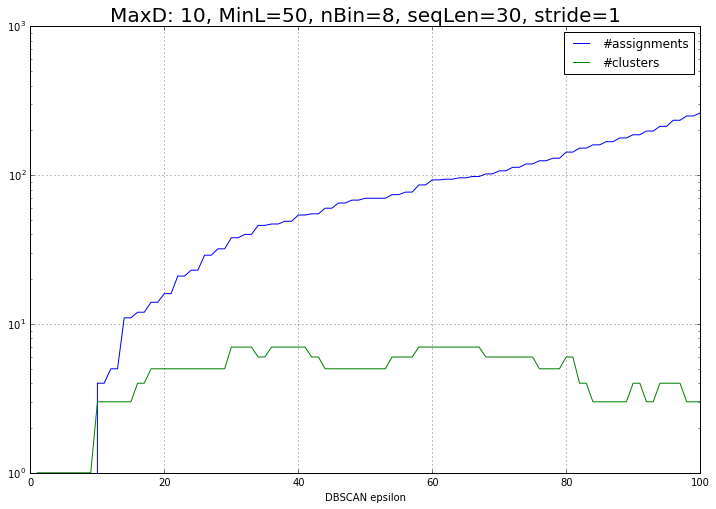

In [60]:
test_eps = np.linspace(1,100,100)

figsize(12,8)
plt.title('MaxD: 10, MinL=50, nBin=8, seqLen=30, stride=1',fontsize=20)
plt.plot(test_eps,n_assignments_per_eps, label='#assignments')
plt.plot(test_eps,n_clusters_per_eps, label='#clusters')
plt.xlabel('DBSCAN epsilon')
#plt.xticks(np.linspace(1,100,25))
plt.yscale('log')
plt.legend()
plt.grid()